In [1]:
from yamlu import ls
from yamlu.coco_read import CocoReader
from pathlib import Path
import cv2
from modules.utils import *
from modules.eval import *
#from modules.dataset_loader import *

dataset_path = Path("../BPMN to XML/data/hdBPMN-COCO")
ls(dataset_path)


bpmn_reader = CocoReader(
    dataset_root=dataset_path,
    arrow_categories=["sequenceFlow", "messageFlow", "dataAssociation"],
)

train_anot = bpmn_reader.parse_split("train")
train_anot2 = bpmn_reader.parse_split("val")
test_anot = bpmn_reader.parse_split("test")

c:\Users\kofb\AppData\Local\anaconda3\envs\newBPMN\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 92/92 [00:01<00:00, 91.08it/s]


In [2]:
from torchvision import transforms

blur_prob = 0.01
color_jitter_prob = 0.02

transformation = transforms.Compose([
    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=(3, 5), sigma=(1, 3)),
    ], p=blur_prob),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.5, contrast=0.3, saturation=0.3),
    ], p=color_jitter_prob),
    transforms.ToTensor()
])

transformation_test = transforms.Compose([
    transforms.ToTensor()
])


In [3]:
from modules.dataset_loader import create_loader, collate_fn
from torch.utils.data import DataLoader, Subset


parameters = {
    'batch_size': 4,
    'crop_prob': 0.2,
    'rotate_90_proba': 0.2,
    'h_flip_prob': 0.2,
    'v_flip_prob': 0.2,
    'max_rotate_deg': 3,
    'rotate_proba': 0.2,
    'keep_ratio': 0.8
}

new_size = (1333,1333)
model_type='object'

train_loader = create_loader(new_size,transformation,train_anot,train_anot2, batch_size=parameters['batch_size'], crop_prob=parameters['crop_prob'], rotate_90_proba=parameters['rotate_90_proba'], h_flip_prob=parameters['h_flip_prob'], v_flip_prob=parameters['v_flip_prob'], max_rotate_deg=parameters['max_rotate_deg'], rotate_proba=parameters['rotate_proba'], keep_ratio=parameters['keep_ratio'], model_type = model_type)

test_loader = create_loader(new_size, transformation_test, test_anot, batch_size=1, model_type = model_type)

original_test_dataset = test_loader.dataset
indices = list(range(50))
subset_test_dataset = Subset(original_test_dataset, indices)
subset_test_loader = DataLoader(subset_test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)



Loaded 308 annotations.
Loaded 102 annotations.
Loaded 92 annotations.


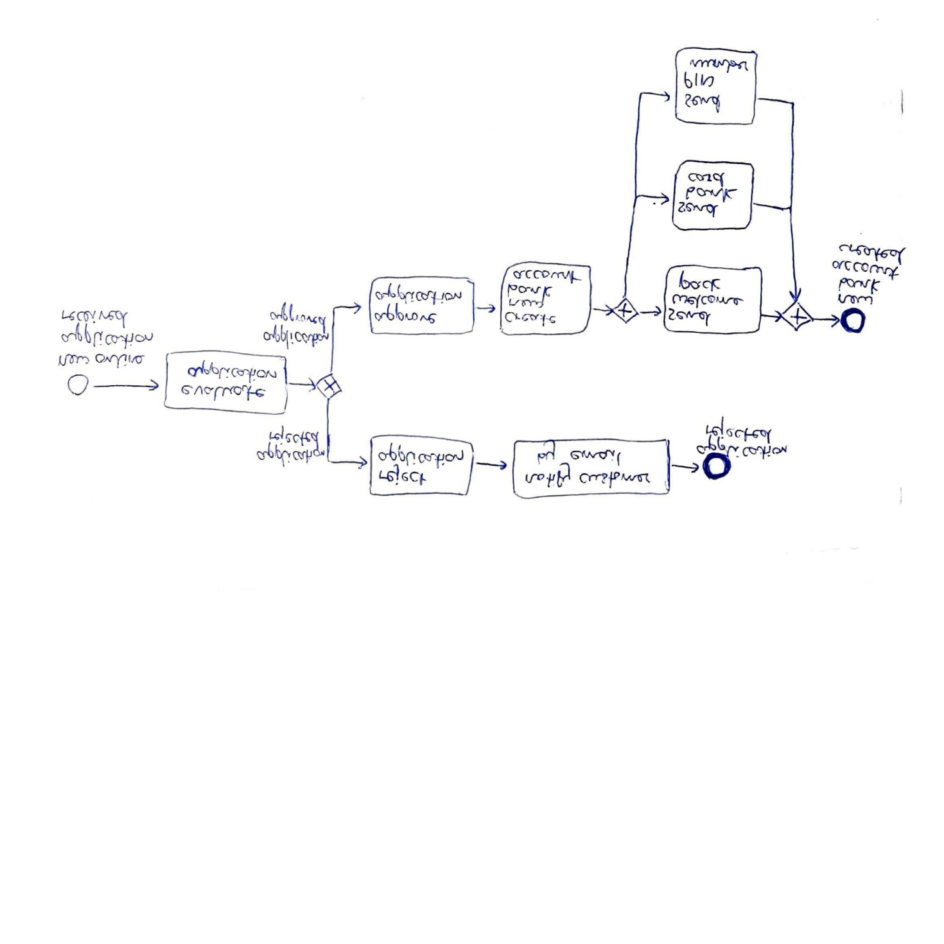

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
#from modules.utils import draw_annotations

image, target = train_loader.dataset[17]

draw_annotations(image, target=target, draw_keypoints=True, draw_boxes=False, write_class=False, axis=False)



In [5]:
from modules.train import *


opti='Adam'


if model_type == 'arrow':
  model_dict = arrow_dict
elif model_type == 'object':
  model_dict = object_dict

model_to_load = None
model_to_load = 'model_object'
model, optimizer, device = prepare_model(model_dict,opti,learning_rate= 0.0001,model_to_load=model_to_load,model_type=model_type)

#for name, param in model.named_parameters():
    # Disable all gradients first
    #param.requires_grad = False

loss_config = {
    'loss_classifier': True,
    'loss_box_reg': True,
    'loss_objectness': True,
    'loss_rpn_box_reg': True
}

Model 'model_object'  loaded


In [ ]:
num_epochs = 1
#information about the training
information_training = 'finetune'
early_stop_f1_score = 0.99
score_threshold = 0.5
if model_to_load is None or model_to_load == 'model_object' or model_to_load == 'model_arrow':
  start_epoch = 0
eval_metric='f1_score'
model = training_model(num_epochs, model, train_loader, test_loader,
                       optimizer, model_to_load, change_learning_rate=100, start_key=100, parameters=parameters, blur_prob=blur_prob, save_every=1,
                       score_threshold=score_threshold, iou_threshold=0.6, early_stop_f1_score=early_stop_f1_score, eval_metric=eval_metric,
                       information_training=information_training, loss_config=loss_config, start_epoch=start_epoch, device=device, model_type = model_type)
